In [1]:
# HTML code to toggle code cell visibility
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/
jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="
javascript:code_toggle()"><input type="submit" 
value="Click here to toggle on/off the raw code."></form>
''')

---

<h1 style="color:#ff0090">Decoding the Dress Code 👗: Deep Learning for Automated Fashion Item Detection</h1>

---

*COSCI 223 - Machine Learning 3*

*Prepared by Erika G. Lacson*

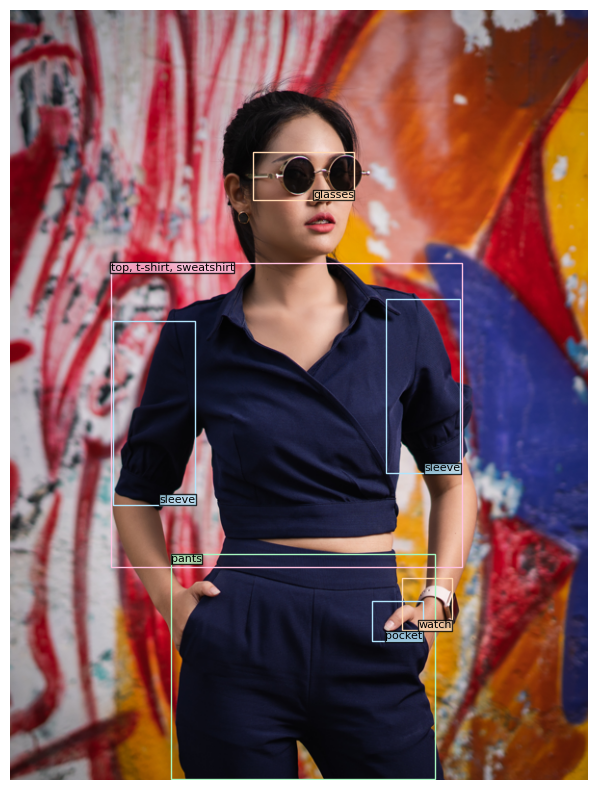

--- 
<h1 style="color:#ff0090">INTRODUCTION</h1>

In the vibrant world of e-commerce, the fashion industry is a runway of its own. But what if we could decode the dress code of this runway, not with a designer’s eye, but with the precision of Deep Learning (DL)? Today, we’re going to unravel the threads of this intriguing possibility. We’ll be using a pretrained model and PyTorch Lightning¹ to automate the process of product tagging, transforming a time-consuming task into a swift, efficient process. This isn’t just a backstage pass to the world of DL in fashion, it’s a front-row seat to a revolution in e-commerce operations. So, if you’re ready to see how deep learning can decode the dress code of the digital fashion world, suit up!

This notebook is divided into two key parts: ‘Fine-Tuning a Pretrained Model’ and ‘Inferencing’. The ‘Fine-Tuning a Pretrained Model’ part starts in the next section until the Finetuning with Pytorch Lightning section where I provided a detailed demonstration of how we can adjust a pretrained model to better suit our specific fashion item detection needs. Meanwhile, the ‘Inferencing’ part is dedicated to those who wish to immediately utilize the model for multiple fashion item detection. Feel free to jump straight to the Inferencing section if you’re eager to see the model in action.

--- 
<h1 style="color:#ff0090">SETTING THE STAGE</h1>

To begin our fashion show, we must prepare the stage by configuring our Python environment with PyTorch Lightning¹ — a PyTorch wrapper that streamlines code management and accelerates model training. Additionally, we’ll incorporate essential packages below for training and inference:

In [3]:
# # Install packages
# !pip install torch==2.0.0
# !pip install pytorch-lightning==2.0.1
# !pip install datasets==2.11.0
# !pip install transformers==4.30.1
# !pip install huggingface_hub==0.14.1

Next, let's import the following modules:

In [3]:
# Importing necessary libraries for data manipulation and visualization
import random
import numpy as np
import matplotlib.pyplot as plt
import shutil
import glob
import os

# Libraries for image processing
from PIL import Image, ImageDraw

# Utility to download a file from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Function to split your data into training and testing datasets
from sklearn.model_selection import train_test_split

# Libraries for handling datasets
import datasets
from datasets import load_dataset, concatenate_datasets, DatasetDict

# PyTorch Lightning for high-performance AI research
import lightning as pl
from lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# PyTorch for building and training neural networks
import torch
import torch.nn as nn

# DataLoader for creating an iterable over the dataset
from torch.utils.data import DataLoader

# Libraries for image transformations
from torchvision import transforms
from torchvision.transforms import ToPILImage, ToTensor

# Transformers library for handling models
from transformers import AutoModelForObjectDetection
from transformers import YolosFeatureExtractor, YolosForObjectDetection

--- 
<h1 style="color:#ff0090">LOADING THE DATA</h1>

The dataset for this project is the Fashionpedia dataset², hosted on Hugging Face containing over 46,000 images with bounding box anotations for multiple fashion objects. This dataset is a subset of the Fashionpedia³ which is a large-scale fashion dataset where each image is annotated with segmentation masks and fine-grained fashion attributes. It’s a rich dataset that’s perfect for our task of fashion item detection.

To use the dataset, let’s load it using the Hugging Face datasets library. For this project, I only used 30% of the dataset just to demonstrate how to finetune an existing pretrained model for fashion item detection task:

In [7]:
%%capture
# Load 30% of the train dataset
dataset = load_dataset("detection-datasets/fashionpedia", split='train[:30%]')

# Generate the split indices
train_val_test_split = dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% for val and test
val_test_split = train_val_test_split['test'].train_test_split(test_size=0.5, seed=42)  # Split the 20% equally into val and test

# Store the splits back into a DatasetDict
final_splits = DatasetDict({
    'train': train_val_test_split['train'],
    'val': val_test_split['train'],
    'test': val_test_split['test']
})

# Unpack the DatasetDict to train, val, test datasets
train_dataset, val_dataset, test_dataset = final_splits['train'], final_splits['val'], final_splits['test']


<br>
<b>Our train, validation, and test datasets should look like this:</b>
<br>

In [8]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 10949
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 1369
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 1369
 }))

<br>
<b>Also, let's display the details of one image:</b>

In [9]:
test_dataset[0]

{'image_id': 14991,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=676x1024 at 0x7FD6598A1CA0>,
 'width': 676,
 'height': 1024,
 'objects': {'bbox_id': [117814, 117815, 117816, 117817, 117818],
  'category': [23, 23, 6, 1, 14],
  'bbox': [[174.0, 862.0, 299.0, 969.0],
   [309.0, 634.0, 420.0, 759.0],
   [127.0, 530.0, 380.0, 903.0],
   [226.0, 221.0, 420.0, 610.0],
   [254.0, 97.0, 395.0, 199.0]],
  'area': [6797, 7354, 35017, 30388, 6175]}}

**The contents of the dataset have the following fields, as documented in the yolos-fashionpedia dataset card**
[(Fashionpedia dataset)](https://huggingface.co/datasets/detection-datasets/fashionpedia):

```Python
{'image_id': Value(dtype='int64'),
'image': Image(decode=True),
'width': Value(dtype='int64'),
'height': Value(dtype='int64'),
'objects': Sequence(feature={
  'bbox_id': Value(dtype='int64'), 
  'category': ClassLabel(num_classes=46, names=['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']), 
  'bbox': Sequence(feature=Value(dtype='float64'), length=4), 
  'area': Value(dtype='int64')}, 
length=-1)}
```
<br>
<br>
<b>Data Fields</b>

The dataset has the following fields²:

- <b>image_id</b>: A unique numeric ID assigned to each image.

- <b>image</b>: An instance of the PIL.Image.Image class that represents the image.

- <b>width</b>: The width of the image.

- <b>height</b>: The height of the image..

- <b>objects</b>: A dictionary that contains metadata related to the bounding boxes of objects present in the image:

    - <b>bbox_id</b>: A unique numeric ID assigned to each bounding box annotation.

    - <b>category</b>: The category of the object.

    - <b>area</b>: The area covered by the bounding box.

    - <b>bbox</b>: The coordinates of the object’s bounding box in the Pascal VOC format.

--- 
<h1 style="color:#ff0090">PRETRAINED MODELS AND TRANSFER LEARNING</h1>

As mentioned earlier, in this blog we’ll harness the power of pretrained models. These models, trained on large datasets, have already learned a lot of features and patterns. By using these models, we can leverage their learning and apply it to our specific task. This is especially useful when we have a limited amount of data for our task or when we want to save time and computational resources.

In our case, we’ll use the YOLOs-Fashionpedia⁴ model, which has been pretrained on the YOLO-Small⁵ architecture. This model has already learned to detect various fashion items, making it a perfect starting point for our task.

--- 
<h1 style="color:#ff0090">HELPER FUNCTIONS</h1>

In the course of executing this project, I discovered a substantial resource in Valentina Feruere Vega’s GitHub repository⁶. This repository furnished a comprehensive guide on fine-tuning the Fashionpedia dataset, a process that was integral to this project. To streamline the handling of our dataset and make it compatible with the YOLO-Small model, I have compiled a set of helper functions. These functions are specifically designed to reconcile the discrepancy between the bounding box (bbox) format used in the Fashionpedia dataset (x1, x2, y1, y2) and the format required by YOLO-Small (x_center, y_center, width, height):

In [ ]:
def xyxy_to_xcycwh(box):
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

To preprocess the images from the dataset, which are stored as PILImage objects, we will utilize the YOLOS Feature Extractor. This feature extractor will transform the images into a tensor format consisting of numerical values. This preprocessing step is essential for further analysis and manipulation of the images within the YOLOS framework.

In [4]:
# Load our feature extractor: yolos-small
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small', size=816, max_size=864)

Now we can apply the following transformations to make it compatible with the model:

In [11]:
def rescale_bboxes(out_bbox, size, down=True):
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def transform(batch):
    inputs = {}
    inputs['pixel_values'] = feature_extractor(batch['image'], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [12]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)
prepared_test = test_dataset.with_transform(transform)

To streamline the training process with batches, a collator function is necessary. This function takes a list of inputs, typically dictionaries in this context, and transforms them into a single input where the data is stacked. In other words, a list of dictionaries will be converted into a dictionary where the values of each key become a vector. This collator function plays a crucial role in efficiently training a model by organizing the data into batch-friendly structures.

In [ ]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

# cats = train_dataset.features['objects'].feature['category']

In [13]:
# The following will be used in loading batches into the model
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(prepared_test, collate_fn=collate_fn, batch_size=BATCH_SIZE)

--- 
<h1 style="color:#ff0090">FINE-TUNING WITH PYTORCH LIGHTNING</h1>

With our stage set and our performers ready, it’s time for the rehearsal.

Fine-tuning is like a dress rehearsal for our model. It involves training the model on our specific task using PyTorch Lightning¹, allowing it to learn from the fashion items present in our images. This way, when it’s time for the actual performance, our model is ready to identify and categorize the fashion items accurately.

To do this, we’ll use PyTorch Lightning¹, a wrapper for PyTorch that simplifies the training process. With PyTorch Lightning¹, we can easily define our training loop, configure our optimizer, and set up our learning rate scheduler. It also provides built-in support for logging metrics, saving checkpoints, and more.

Let’s finetune an existing model, YOLOs-Fashionpedia⁴, that has already been finetuned on a fashion item detection task. Here's a simplified version of the finetuning process:

In [14]:
class Yolos(pl.LightningModule):
    
    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained("valentinafeve/yolos-fashionpedia", 
                                                                 num_labels=46,
                                                                 ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs
    
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        
        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("test_loss", loss)
        for k,v in loss_dict.items():
            self.log("test_" + k, v.item())
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer
    
    def train_dataloader(self):
        return train_dataloader
    
    def val_dataloader(self):
        return val_dataloader
    
    def test_dataloader(self):
        return test_dataloader

In [15]:
# To save and view the logs later 
logger = CSVLogger("logs", name="detr_logs")

In finetuning a pretrained model like YOLO-Small using transfer learning, a lower learning rate and weight decay are utilized to preserve the useful features the model has already learned and prevent overfitting on the new task. A lower learning rate ensures that the weight updates during training are incremental and do not disrupt the previously learned patterns, thus allowing the model to subtly adapt to the new task. Weight decay, on the other hand, helps to maintain small weights, thus preventing overfitting by ensuring the model doesn’t rely too heavily on any particular feature and remains generalized. These parameters strike a balance between leveraging the power of the pretrained model and fitting it to the new task effectively.

In [16]:
model = Yolos(lr=2.5e-5, weight_decay=1e-4)

For illustration purposes, I trained the model for a maximum of 3 training steps.

In [38]:
trainer = pl.Trainer(max_epochs=3, logger=logger, accelerator="cuda", devices=1)
trainer.fit(model, train_dataloader, val_dataloader)

<b>After training the model, you may now save it and use it for inferencing.</b>

In [29]:
# Save the model
trainer.save_checkpoint('./model/fashion_model.ckpt')

--- 
<h1 style="color:#ff0090">GROUPING CATEGORIES</h1>

Once the model is fine-tuned, it’s showtime! Given an image of a person modeling fashion items, the model will detect and classify the items into 46 different classes.

However, outputting raw class labels might not be the most user-friendly way to present the results. Hence, I decided to group these classes into broader categories such as “Tops and Outerwear”, “Bottoms”, and “Footwear”. For example, the classes ‘shirt, blouse’ and ‘top, t-shirt, sweatshirt’ both fall under the category ‘Tops and Outerwear’.

Here’s the Python code for creating the group mappings:

In [5]:
# Group the categories based on types
group_tops_outerwear = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'coat', 'cape', 'dress', 'jumpsuit']
group_bottoms = ['pants', 'shorts', 'skirt']
group_footwear = ['shoe', 'sock']
group_accessories = ['glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'bag, wallet', 'scarf', 'umbrella']
group_clothing_details = ['hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper']
group_embellishments = ['applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

group_mapping = {}
for category in group_tops_outerwear:
    group_mapping[category] = 'Tops and Outerwear'
for category in group_bottoms:
    group_mapping[category] = 'Bottoms'
for category in group_footwear:
    group_mapping[category] = 'Footwear'
for category in group_accessories:
    group_mapping[category] = 'Accessories'
for category in group_clothing_details:
    group_mapping[category] = 'Clothing Details'
for category in group_embellishments:
    group_mapping[category] = 'Embellishments'

With these mappings, we can translate the model’s raw output into more understandable categories. A user can input an image of a person modeling fashion items, and the model will output the detected items, grouped into categories such as ‘Tops and Outerwear’, ‘Bottoms’, ‘Footwear’, ‘Accessories’, ‘Clothing Details’, and ‘Embellishments’.

Here’s a sneak peek of what the output might look like:

```python
Tops and Outerwear: top/t-shirt/sweatshirt
Clothing Details: pocket, neckline
Bottoms: pants
Embellishments: rivet
Footwear: shoe
```
<br>
I've also added a color-coding feature for these categories, making the results more visually appealing and easier to understand.


In [6]:
color_mapping = {
    'Tops and Outerwear': '#FFC1E0',       # Light pink
    'Bottoms': '#A7F7C0',                   # Light green
    'Footwear': '#E1BEE7',                  # Light purple
    'Accessories': '#FFD8B1',                # Light orange
    'Clothing Details': '#B3E5FC',           # Light blue
    'Embellishments': '#FFF9C4'              # Light yellow
}

--- 
<h1 style="color:#ff0090">INFERENCING</h1>

<b>To use the model for inferencing, specifically for fashion item detection as well as for automated product tagging, you just need to perform the following steps:</b>

In [20]:
%%capture
# Load the pretrained feature extractor from the YOLO-small model
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')

# Load the model from a checkpoint, setting the learning rate and weight decay
model_tags = Yolos.load_from_checkpoint(
    checkpoint_path='./model/fashion_model.ckpt',  # Path to the checkpoint
    lr=2.5e-5,  # Learning rate for fine-tuning
    weight_decay=1e-4  # Weight decay for regularization
)

<br>

<b>Just execute the following helper functions for inferencing. This is just a summarization of the functions and tasks that I mentioned earlier in this notebook:</b>

In [21]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def idx_to_text(i):
    return cats_list[i]

cats_list = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 
             'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 
             'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 
             'headband, head covering, hair accessory', 'tie',
             'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 
             'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
             'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 
             'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 
             'rivet', 'ruffle', 'sequin', 'tassel']

# Group the categories based on types
group_tops_outerwear = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'coat', 'cape', 'dress', 'jumpsuit']
group_bottoms = ['pants', 'shorts', 'skirt']
group_footwear = ['shoe', 'sock']
group_accessories = ['glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'bag, wallet', 'scarf', 'umbrella']
group_clothing_details = ['hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper']
group_embellishments = ['applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

group_mapping = {}
for category in group_tops_outerwear:
    group_mapping[category] = 'Tops and Outerwear'
for category in group_bottoms:
    group_mapping[category] = 'Bottoms'
for category in group_footwear:
    group_mapping[category] = 'Footwear'
for category in group_accessories:
    group_mapping[category] = 'Accessories'
for category in group_clothing_details:
    group_mapping[category] = 'Clothing Details'
for category in group_embellishments:
    group_mapping[category] = 'Embellishments'

color_mapping = {
    'Tops and Outerwear': '#FFC1E0',       # Light pink
    'Bottoms': '#A7F7C0',                   # Light green
    'Footwear': '#E1BEE7',                  # Light purple
    'Accessories': '#FFD8B1',                # Light orange
    'Clothing Details': '#B3E5FC',           # Light blue
    'Embellishments': '#FFF9C4'              # Light yellow
}


def plot_results(pil_img, prob, boxes, show_image=True):
    if show_image:
        plt.figure(figsize=(16, 10))
        plt.imshow(pil_img)
        ax = plt.gca()
    unique_categories = {}

    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        category = idx_to_text(cl)
        group = group_mapping[category]
        color = color_mapping[group]

        if show_image:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=color, linewidth=1))

            # Determine the label position based on the category
            if group in ['Accessories', 'Clothing Details', 'Embellishments']:
                label_x = xmax  # Position the label in the lower right corner of the bounding box
                label_y = ymax  # Position the label in the lower right corner of the bounding box
                ha = 'right'
                va = 'bottom'
            else:
                label_x = xmin  # Position the label in the upper left corner of the bounding box
                label_y = ymin  # Position the label in the upper left corner of the bounding box
                ha = 'left'
                va = 'top'

            ax.text(label_x, label_y, category, fontsize=8, ha=ha, va=va,
                    bbox=dict(facecolor=color, alpha=0.8, pad=0.2))

        if group not in unique_categories:
            unique_categories[group] = set()
        unique_categories[group].add(category)

    if show_image:
        plt.axis('off')
        plt.show()

    for group, categories in unique_categories.items():
        # Convert categories to a list with '/' separator, then join them
        detected = ', '.join([', '.join(word.split(', ')).replace(', ', '/') for word in categories])

        # Print group and corresponding category string
        print(f"{group}: {detected}")
    print("\n\n")

def visualize_predictions(image, outputs, threshold=0.7, show_image=True):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled, show_image)
    
    
def fix_channels(t):
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)


def process_image(IMAGE_PATH, threshold=0.7, show_image=True):
    print(IMAGE_PATH)

    image = Image.open(open(IMAGE_PATH, "rb"))
    image = fix_channels(ToTensor()(image))
    image = image.resize((600, 800))
    
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model_tags(**inputs)
    
    img = visualize_predictions(image, outputs, threshold, show_image)

    return img

def process_images(image_paths, threshold=0.7, show_image=True):
    results = []
    for image_path in image_paths:
        result = process_image(image_path, threshold, show_image)
        results.append(result)
    return results

--- 
<h1 style="color:#ff0090">SHOW TIME!</h1>

Let's work on an image. To do this, use `process_images()` function. 

- `image_path`: accepts a list of image paths, you can put a string of an image path inside a list. e.g.,: ["images/0.jpg"].
- `threshold`: defaults to 70% or 0.7. It is used to keep only those predictions whose maximum confidence score is greater than the threshold. 
- `show_image`: defaults to True. This is to control whether you want to display the image with the fashion items detected inside bounding boxes (True) or not (False). 

<br>

<b>That's it! Let's try it on a single image:</b>

```Python
# Single image, show_image=True
IMAGE_PATH = ["images/sample_01.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=True);
```

images/sample_01.jpg


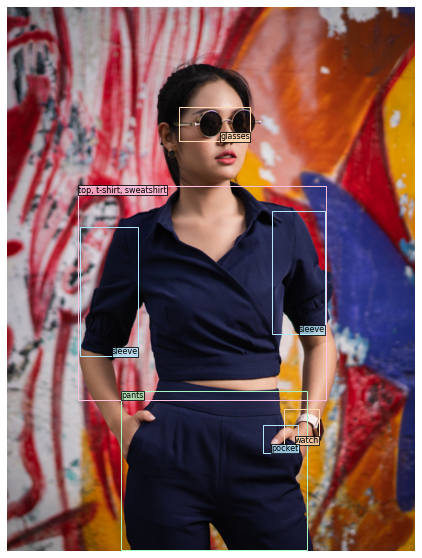

Accessories: watch, glasses
Clothing Details: pocket, sleeve
Tops and Outerwear: top/t-shirt/sweatshirt
Bottoms: pants





In [22]:
# Single image, show_image=True
IMAGE_PATH = ["images/sample_01.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=True);

<br>

<b>If you want to use it for automated fashion item tagging and get the printed results only, you can input `show_image=False` instead: </b>

```Python
# Single image, show_image=False
IMAGE_PATH = ["images/sample_01.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=False);
```

In [23]:
# Single image, show_image=False
IMAGE_PATH = ["images/sample_01.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=False);

images/sample_01.jpg
Accessories: watch, glasses
Clothing Details: pocket, sleeve
Tops and Outerwear: top/t-shirt/sweatshirt
Bottoms: pants





<br>

<b>Finally, if you want to use it for multiple images, you can either specify multiple image paths inside the `image_paths` parameter or use the following `process_images_in_directory()` function and feed it your path to your image directory. </b>

<br>

<b>Option 1: multiple image paths</b>
```Python
# Multiple images, show_image=True
IMAGE_PATH = ["images/sample_01.jpg", "images/sample_02.jpg", "images/sample_03.jpg", "images/sample_04.jpg"]
process_images(IMAGE_PATH, threshold=0.8, show_image=False);
```

<br>
<b>Option 2: using path to your image directory</b>

```Python
def process_images_in_directory(directory='./images', threshold=0.70, show_image=True):
    # Define the extensions for the image files you're interested in
    image_extensions = ['jpg', 'png', 'jpeg', 'JPG', 'PNG']

    # Use a list comprehension to create a list of files for each extension, then combine these lists
    image_files = [glob.glob(f'{directory}/*.{ext}') for ext in image_extensions]
    image_paths = [item for sublist in image_files for item in sublist]  # flatten the list

    return process_images(image_paths, threshold=threshold, show_image=show_image)

process_images_in_directory(directory='./images', threshold=0.8, show_image=True)
```

<b>Both options will output the following:</b>

./images/sample_05.jpg


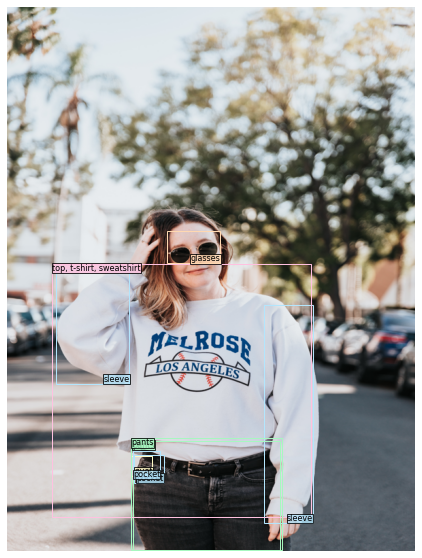

Embellishments: rivet
Clothing Details: pocket, sleeve
Accessories: glasses
Bottoms: pants
Tops and Outerwear: top/t-shirt/sweatshirt



./images/sample_04.jpg


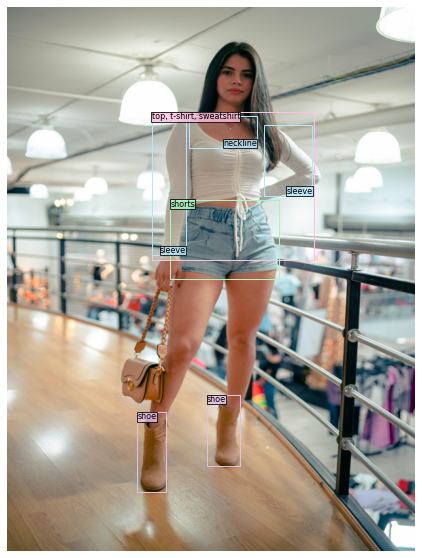

Clothing Details: neckline, sleeve
Footwear: shoe
Tops and Outerwear: top/t-shirt/sweatshirt
Bottoms: shorts



./images/sample_03.jpg


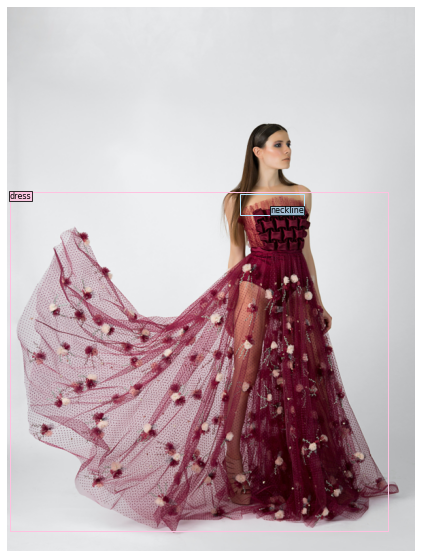

Clothing Details: neckline
Tops and Outerwear: dress



./images/sample_02.jpg


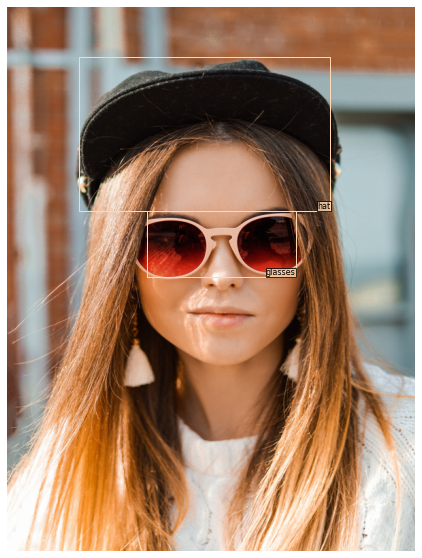

Accessories: glasses, hat



./images/sample_01.jpg


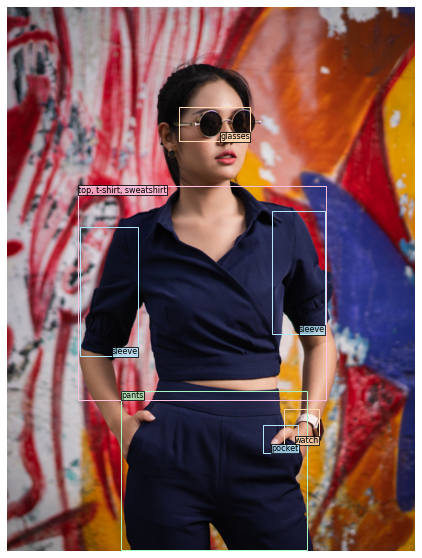

Accessories: watch, glasses
Clothing Details: pocket, sleeve
Tops and Outerwear: top/t-shirt/sweatshirt
Bottoms: pants





In [24]:
def process_images_in_directory(directory='./images', threshold=0.70, show_image=True):
    # Define the extensions for the image files you're interested in
    image_extensions = ['jpg', 'png', 'jpeg', 'JPG', 'PNG']

    # Use a list comprehension to create a list of files for each extension, then combine these lists
    image_files = [glob.glob(f'{directory}/*.{ext}') for ext in image_extensions]
    image_paths = [item for sublist in image_files for item in sublist]  # flatten the list

    return process_images(image_paths, threshold=threshold, show_image=show_image)
process_images_in_directory(directory='./images', threshold=0.8, show_image=True);

--- 
<h1 style="color:#ff0090">WRAPPING UP</h1>

The potential impact of this project in the realm of e-commerce is substantial. By decoding the dress code with Automated Fashion Item Detection, we can expedite the process of uploading new products, enhancing operational efficiency. This is not just about identifying fashion items; it’s about improving the customer experience by providing accurate product descriptions and facilitating efficient product search.

Moreover, this technology can be extended to other applications such as inventory management, trend analysis, and personalized shopping experiences. It’s about understanding the language of fashion and using it to our advantage.

--- 
<h1 style="color:#ff0090">CONCLUSION</h1>

In this exploration, we’ve decoded the dress code of the fashion industry. We’ve used the precision of DL, a pretrained model, and PyTorch Lightning to automate the process of fashion item detection and to demonstrate how we can leverage deep learning to perform automated product tagging. This can transform a time-consuming task into a swift, efficient process.

By decoding the dress code, we’ve opened up a world of possibilities in the realm of e-commerce. This is just the beginning. As we continue to refine these technologies, we can look forward to even more innovative and efficient solutions in the future.

--- 
<h1 style="color:#ff0090">NOTE</h1>

This blog post is intended for educational purposes and is meant to provide a high-level overview of the process of using pretrained models for object detection in the fashion industry. The actual implementation may require additional steps and considerations, depending on the specific requirements of your project. But given the benefits of automating tasks, it’s an exciting journey to embark on that I would certainly continue after I graduate.

--- 
<h1 style="color:#ff0090">References</h1>

- [1] PyTorch Lightning. (n.d.). Retrieved from https://www.pytorchlightning.ai/
- [2] Blin, J. (n.d.). Fashionpedia. Hugging Face. Retrieved June 27, 2023, from
https://huggingface.co/datasets/detection-datasets/fashionpedia
- [3] Jia, M., Shi, M., Sirotenko, M., Cui, Y., Cardie, C., Hariharan, B., Adam, H., & Belongie, S. (2020). Fashionpedia: Ontology, Segmentation, and an Attribute Localization Dataset. In Proceedings of the European Conference on Computer Vision (ECCV).
- [4] Feruere Vega, V. (n.d.). YOLOS-fashionpedia. Hugging Face. Retrieved June 27, 2023, from
https://huggingface.co/valentinafeve/yolos-fashionpedia
- [5] Wang, X. (n.d.). YOLOS-small. Hugging Face. Retrieved June 27, 2023, from
https://huggingface.co/hustvl/yolos-small
- [6] Feruere Vega, V. (2023, June 13). Fine tunning YOLOs for fashion [Source code]. GitHub. https://github.com/valentinafeve/fine_tunning_YOLOS_for_fashion